In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow
import numpy as np
from scipy.integrate import solve_ivp
from scipy.io import loadmat

import pysindy as ps

# Quasiperiodic cavity flow

This Jupyter notebook example is written by Jared Callaham and demonstrates the use of SINDy to learn a model for the quasiperiodic dynamics in a shear-driven cavity at Re=7500, following [Callaham, Brunton, and Loiseau (2021)](https://arxiv.org/abs/2106.02409).  It will focus on working through a relatively involved fluid dynamics example, rather than comparing optimizers, libraries, etc.  This example also includes some other more advanced SINDy "tricks" like using dynamic mode decomposition to rotate the generalized coordinates and co-opting some of the SINDy infrastructure to perform nonlinear dimensionality reduction.

An interactive version of this notebook is available on binder
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/dynamicslab/pysindy/v1.7.3?filepath=examples/14_cavity_flow.ipynb)

As in the cylinder wake example (see notebook 3), the reduced-order model appproximates the 2D time-varying velocity field $\mathbf{u}(\mathbf{x}, t)$ with the POD expansion
$$
\mathbf{u}(\mathbf{x}, t) = \sum_{j=1}^r \boldsymbol{\psi}_j(\mathbf{x}) a_j(t).
$$
The POD expansion gives us the spatial modes $\boldsymbol{\psi}_j(\mathbf{x})$ and a time series for the coefficients $a_j(t)$.  This time series serves as the training data; if we can learn an ODE model
$$
\dot{\mathbf{a}} = \mathbf{f}(\mathbf{a})
$$
for the coefficients then we can evaluate the model cheaply and reconstruct the full velocity field.

__Note on comparison with the paper:__ this example departs slightly from the paper above for two reasons.  First, scikit-learn doesn't support complex coefficients, so here we'll split into real and imaginary parts.  This works reasonably well, but doesn't take advantage of the symmetries in the same way, so the models won't be quite as compact as in the paper (where analysis used a non-PySINDy implementation of FROLS).  Second, the paper used 50-60 modes for most of the analysis; to keep this example lightweight we'll stick with 12 modes.  The idea is same, just the model we get here won't be quite as accurate.

## 1. POD analysis

Since the full Direct Numerical Solution (DNS) fields and POD modes are too large to store in a standard GitHub repository, we'll just start with the set of POD coefficients $\mathbf{a}(t)$.  Since our POD modes represent velocity components, the squared amplitude of each mode $|a_j|^2$ is conveniently equivalent to the kinetic energy content of that mode and also the singular values or POD eigenvalues (see standard references on POD like [this](https://www.cambridge.org/core/books/turbulence-coherent-structures-dynamical-systems-and-symmetry/4D353229751BBB24C8C266B4714CA9F2) or [this](https://arc.aiaa.org/doi/10.2514/1.J056060)).

Text(0.5, 0, 'Mode index')

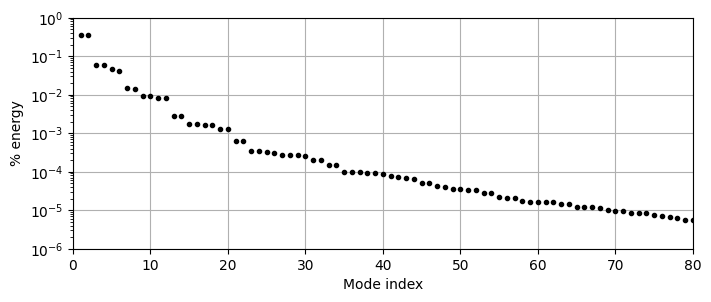

In [2]:
# Load .mat file with the POD data
data = loadmat("data/cavityPOD.mat")

t_dns = data['t'].flatten()
dt_dns = t_dns[1] - t_dns[0]
a_dns = data['a']
singular_vals = data['svs'].flatten()

# Plot singular values, sorted by energy content and normalized to the sum
plt.figure(figsize=(8, 3))
plt.semilogy(1 + np.arange(len(singular_vals)), 
             singular_vals / sum(singular_vals), 'k.')
plt.grid()
plt.xlim([0, 80])
plt.ylim([1e-6, 1e0])
plt.ylabel("% energy")
plt.xlabel("Mode index")

Although the energy doesn't decay quite as quickly as in the cylinder example, by $r=12$ the POD modes contain $< 0.01 \%$ of the total fluctuating (mean-subtracted) kinetic energy, and by $r=64$ it has dropped to $\sim 0.001 \%$.

It is also helpful to look at the power spectral density; note the approximately discrete peaks in log-energy.  These are characteristic of quasiperiodic dynamics generated by oscillations at incommensurate frequencies.

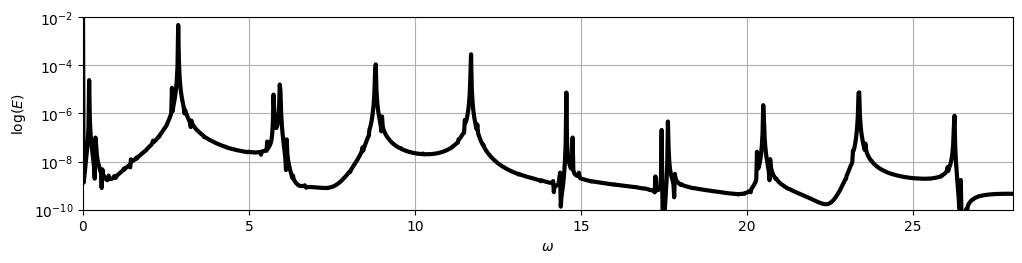

In [3]:
# Basic power spectral density estimate using FFT
def psd_est(E, dt=1):
    Ehat = np.abs((dt * np.fft.fft(E)) ** 2)
    Ehat = Ehat[:int(len(Ehat) / 2)]
    N = len(Ehat)
    freq = 2 * np.pi * np.arange(N) / (2 * dt * N)  # Frequencies in rad/s
    return Ehat, freq

E_dns = np.sum(a_dns ** 2, axis=1)  # kinetic energy
psd, freq = psd_est(E_dns, dt=dt_dns)
    
# Plot the power spectral density
plt.figure(figsize=(12, 2.5))
plt.semilogy(freq, psd, 'k', lw=3)
plt.xlim([0, 28])
plt.ylim([1e-10, 1e-2])
plt.xlabel('$\omega$')
plt.ylabel('$\log(E)$')
plt.grid(True)


## 2. Galerkin projection

The standard approach to POD-based reduced-order modeling is to construct a physics-based model for $\mathbf{f}(\mathbf{a})$ using a technique called _Galerkin projection_ (see the paper referenced above for details).  The model is of the form
$$
\dot{\mathbf{a}} = \mathbf{C} + \mathbf{L}\mathbf{a} + \mathbf{Q}(\mathbf{a}),
$$
including terms that are constant, linear, and quadratic in $\mathbf{a}$ ($\mathbf{C}$, $\mathbf{L}$, and $\mathbf{Q}$, respectively).  In general, all of these arrays will be dense, so for a model containing $r$ modes the cost of simulating the reduced-order model scales with $\mathcal{O}(r^3)$.  This can get fairly expensive, but even worse, even if great care is taken in constructing the Galerkin system, this type of model is often inaccurate or unstable.  Our goal is to use SINDy to learn a more efficient and accurate approximation to $\mathbf{f}(\mathbf{a})$, but Galerkin is a convenient baseline

Without getting into the details of computing the Galerkin projection, we'll assume we've already computed this model.  We can try a couple of different values of $r$ to see how it affects the results; based on "drops" in the singular value spectrum $r=6$ and $r=12$ look like reasonable values to try.  Unfortunately it turns out that the $r=12$ model is unstable, so we'll just bump it up to $r=16$.

In [4]:
class GalerkinROM():
    def __init__(self, file):
        model_dict = loadmat(file)
        self.C = model_dict['C'][0]
        self.L = model_dict['L']
        self.Q = model_dict['Q']
        
    def integrate(self, x0, t, r=None,
                  rtol=1e-3, atol=1e-6):
        if r is None: r=len(C)
            
        # Truncate model as indicated
        C = self.C[:r]
        L = self.L[:r, :r]
        Q = self.Q[:r, :r, :r]
            
        # RHS of POD-Galerkin model, for time integration
        rhs = lambda t, x: C + (L @ x) + np.einsum('ijk,j,k->i', Q, x, x)
        
        sol = solve_ivp(rhs, (t[0], t[-1]), x0[:r], t_eval=t, rtol=rtol, atol=atol)
        return sol.y.T

In [5]:
# Simulate Galerkin system at various truncation levels

galerkin_model = GalerkinROM('data/cavityGalerkin.mat')

dt_rom = 1e-2
t_sim = np.arange(0, 300, dt_rom)

a0 = a_dns[0, :]

a_gal6 = galerkin_model.integrate(a0, t_sim, r=6, rtol=1e-8, atol=1e-8)
a_gal16 = galerkin_model.integrate(a0, t_sim, r=16, rtol=1e-8, atol=1e-8)

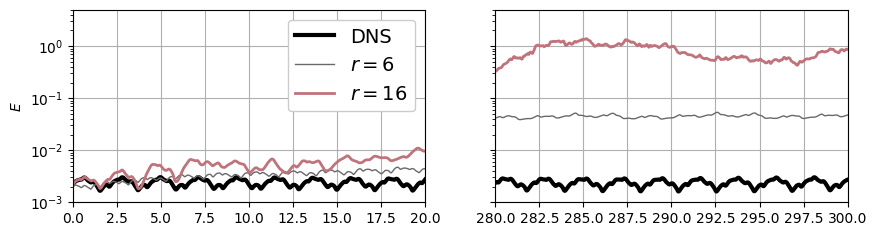

In [6]:
# Plot energies
rE = 16
E_dns = np.sum(a_dns[:, :rE] ** 2, 1)
E_gal6 = np.sum(a_gal6[:, :rE] ** 2, 1)
E_gal16 = np.sum(a_gal16[:, :rE] ** 2, 1)

plt.figure(figsize=(10, 2.5))
plt.subplot(1, 2, 1)
plt.plot(t_dns, E_dns, 'k', label='DNS', lw=3)
plt.plot(t_sim, E_gal6, label='$r=6$', lw=1, c='dimgrey')
plt.plot(t_sim, E_gal16, label='$r=16$', lw=2, c='xkcd:dusty rose')
plt.gca().set_yscale('log')
plt.xlim([0, 20])
plt.ylim([1e-3, 5e0])
plt.ylabel('$E$')
plt.legend(loc=0, fancybox=True, framealpha=1, fontsize=14)
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(t_dns, E_dns, 'k', label='DNS', lw=3)
plt.plot(t_sim, E_gal6, label='$r=6$', lw=1, c='dimgrey')
plt.plot(t_sim, E_gal16, label='$r=16$', lw=2, c='xkcd:dusty rose')
plt.gca().set_yscale('log')
plt.xlim([280, 300])
plt.ylim([1e-3, 5e0])
plt.gca().set_yticklabels([])
plt.grid()

plt.subplots_adjust(wspace=0.2)
plt.show()

Even though the residual energy from truncation is small, the Galerkin model still diverges from the true behavior of the flow.  This is still true if the truncation is extended further (we tested up to $r=64$ in the paper).  And even by $r=16$ that cubic scaling is starting to catch up with us (though it's still a lot faster than DNS!).

## 3. Naive SINDy model

As a first pass at improving the reduced-order model, let's try learning a SINDy model for the POD coefficients, just like we did for the cylinder wake.  The form of the Galerkin model suggests that we should use quadratic terms in the library, but [physical considerations](https://www.cambridge.org/core/journals/journal-of-fluid-mechanics/article/abs/hierarchy-of-lowdimensional-models-for-the-transient-and-posttransient-cylinder-wake/0F114BEB5DD20B7342E99ED8D0070C01) suggest that it would probably be better to include cubic terms.  To keep the size of the library manageable, we won't go higher than that (feel free to try, but it probably won't help).

For truncation level, it might be nice to keep a lot of modes ($r=64$, say), but we have to keep in mind that the library dimension grows _combinatorially_ in the number of variables.  Based on the singular values above, $r=6$ seems like a better place to start (though again, go ahead and experiment).

Also note that we're including _all_ of the DNS data as training data.  This is generally poor practice in machine learning, but in this particular case we expect that the solution stays on its attractor after any initial transients die away, so even if we split the data into train/test we wouldn't really have statistical independence.  You may well wonder if the resulting model is overfit, but a better way to test is by seeing if transient trajectories converge to the attractor (more on this later).

In [7]:
r = 6  # POD truncation

x_train = a_dns[:, :r]
t_train = t_dns.copy()

# Fit the model
optimizer = ps.STLSQ(threshold=1)
library = ps.PolynomialLibrary(degree=3)
model = ps.SINDy(
    optimizer=optimizer, 
    feature_library=library
)
model.fit(x_train, t_train, quiet=True)
model.print()

(x0)' = -11.916 x1 + 43.338 x1 x5
(x1)' = 11.475 x0 + 0.939 x2 + -41.534 x0 x5 + 29.225 x1 x5
(x2)' = -22.933 x3 + -6.035 x0 x1 + -30.179 x0 x3 + -36.053 x0 x4 + -48.359 x1 x5
(x3)' = 22.568 x2 + 6.443 x0^2 + 22.740 x0 x2 + 47.031 x0 x5 + -5.254 x1^2 + -22.714 x1 x3 + -30.409 x1 x4
(x4)' = 3.020 x5
(x5)' = -2.768 x4


So, how did that go?

In [8]:
# Simulate the model
a_sindy = model.simulate(a0[:r], t_sim)
E_sindy = np.sum(a_sindy[:, :rE] ** 2, 1)

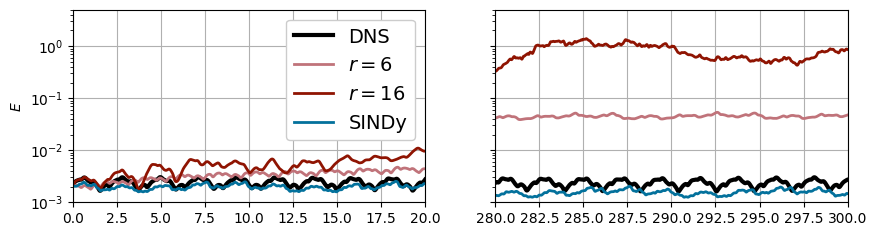

In [9]:
plt.figure(figsize=(10, 2.5))
plt.subplot(1, 2, 1)
plt.plot(t_dns, E_dns, 'k', label='DNS', lw=3)
plt.plot(t_sim, E_gal6, label='$r=6$', lw=2, c='xkcd:dusty rose')
plt.plot(t_sim, E_gal16, label='$r=16$', lw=2, c='xkcd:brick red')
plt.plot(t_sim, E_sindy, label='SINDy', lw=2, c='xkcd:ocean blue')
plt.gca().set_yscale('log')
plt.legend(loc=0, fancybox=True, framealpha=1, fontsize=14)
plt.xlim([0, 20])
plt.ylim([1e-3, 5e0])
plt.ylabel('$E$')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(t_dns, E_dns, 'k', label='DNS', lw=3)
plt.plot(t_sim, E_gal6, label='$r=6$', lw=2, c='xkcd:dusty rose')
plt.plot(t_sim, E_gal16, label='$r=16$', lw=2, c='xkcd:brick red')
plt.plot(t_sim, E_sindy, label='SINDy', lw=2, c='xkcd:ocean blue')
plt.gca().set_yscale('log')
plt.xlim([280, 300])
plt.ylim([1e-3, 5e0])
plt.gca().set_yticklabels([])
plt.grid()

plt.subplots_adjust(wspace=0.2)
plt.show()

That's actually worse than the Galerkin system of the same dimension!

There are a few things we could try to improve this:
* Parameter tuning: try different thresholds, different libraries, truncation, etc.
* Ensemble SINDy
* Different optimizer: sequential least squares (STLSQ) is easy and fast, but often not as good as a more advanced algorithm like SR3
* Use quadratic optimization with constraints (e.g. Trapping SINDy)
* Take advantage of symmetries in the system

Any of these might work and could be worth trying, but in this case we can get some extra mileage by thinking about the problem from a dynamical systems point of view.

## 4. Dynamic mode decomposition

The first thing that's helpful in this case is related to the point spectrum shown above.  Since there are oscillations that occur at approximately discrete frequencies, this flow is a natural candidate for dynamic mode decomposition ([Schmid (2010)](https://www.cambridge.org/core/journals/journal-of-fluid-mechanics/article/abs/dynamic-mode-decomposition-of-numerical-and-experimental-data/AA4C763B525515AD4521A6CC5E10DBD4)), which looks for spatial modes associated with specific frequencies.  Again, we'll skip over many details of how DMD is computed except to say that this is an example of the simple _exact DMD_ algorithm (see [Tu, _et al._ (2014)](https://arxiv.org/abs/1312.0041)).

The core idea is that we want to approximate a discrete-time evolution operator $\mathbf{A}$ that steps the velocity field forward in time:
$$
\mathbf{u}(\mathbf{x}, t_{k+1}) \approx \mathbf{A} \mathbf{u}(\mathbf{x}, t_k).
$$
In particular, we want to look at the "spectral properties" of $\mathbf{A}$, or the eigenvectors and eigenvalues.
The operator $\mathbf{A}$ typically can't be formed explicitly, so we look for a low-rank approximation.  In the exact DMD algorithm, this uses the representation of the flow field in the POD basis, so that
$$
\mathbf{a}(t_{k+1}) \approx \tilde{\mathbf{A}} \mathbf{a}({t_k}),
$$
where $\tilde{\mathbf{A}} = \boldsymbol{\Psi}^T \mathbf{A} \boldsymbol{\Psi}$ is the low-rank approximation of the operator $\mathbf{A}$ in the subspace spanned by the POD modes.
We approximate $\tilde{\mathbf{A}}$ with a pseudoinverse of the time-shifted data.  This is only an $r \times r$ matrix, so its eigenvalue decomposition $\tilde{\mathbf{A}} = \mathbf{V} \boldsymbol{\Lambda} \mathbf{V}^{-1}$ can easily be computed.

In [10]:
from scipy import linalg
dt_dns = t_dns[1] - t_dns[0]

# Leave off shift mode if not computed with modred
X = a_dns[:-1, :].T  # First time step
Y = a_dns[1:, :].T  # Time-shifted matrix so that Y = AX

# Low-rank dynamics via pseudoinverse
A = Y @ linalg.pinv(X)

# Eigendecomposition of low-rank matrix (note these are discrete-time eigenvalues)
dt_evals, V = linalg.eig(A)  
evals = np.log(dt_evals) / dt_dns

The _DMD modes_ $\boldsymbol{\Phi}$ are then linear combinations of the POD modes given by the eigenvectors of $\tilde{\mathbf{A}}$:
$$
\boldsymbol{\Phi} = \boldsymbol{\Psi} \mathbf{V}
$$

Even though the DMD modes $\boldsymbol{\Phi}$ each have a specific frequency associated with them, we can simply treat them as a different set of spatial modes from the POD modes, so that the flow field can be approximated with either the POD or DMD modes:
$$
\mathbf{u}(\mathbf{x}, t) \approx \sum_{j=1}^r \boldsymbol{\psi}_j(\mathbf{x}) a_j(t) = \sum_{j=1}^r \boldsymbol{\phi}_j(\mathbf{x}) \alpha_j(t).
$$
Note that the POD and DMD modes span the same linear subspace; the generalized coordinates $\{a_j\}$ and $\{\alpha_j\}$ are just rotations of one another given by $\mathbf{V}$:
$$
\boldsymbol{\alpha} = \mathbf{V}^{-1} \mathbf{a}.
$$

The DMD coefficients aren't sorted in any order the way the POD coefficients are, so it's helpful to arrange them by descending average energy content (as for POD).

In [11]:
a_dmd = (linalg.inv(V) @ a_dns.T ).T
E_dmd = np.mean(abs(a_dmd) ** 2, axis=0)

sort_idx = np.argsort(-E_dmd)
V = V[:, sort_idx]
evals = evals[sort_idx]

a_dmd = (linalg.inv(V) @ a_dns.T ).T

Why do we bother with DMD if it's the same subspace as POD?

The main reason is that for a flow with discrete power spectrum, the DMD coefficients will be closer to pure oscillation, which can make it easier to identify a simple dynamical systems model.

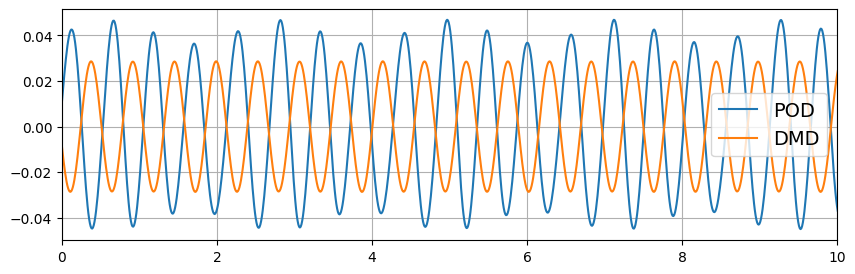

In [12]:
# Compare the most energetic POD and DMD coefficients
plt.figure(figsize=(10, 3))
plt.plot(t_dns, a_dns[:, 0], label='POD')
plt.plot(t_dns, np.real(a_dmd[:, 0]), label='DMD')
plt.xlim([0, 10])
plt.legend(fontsize=14)
plt.grid()
plt.show()

Notice the DMD coefficient has slightly lower amplitude (less energy), but is almost a pure sine, whereas the POD coefficient time series looks like it contains more frequencies.  This tends to make it easier to model the DMD coefficients; pure sine waves can be generated by a simple oscillator model, whereas mixed frequencies and energy transfers between modes are more complicated to construct.

## 5. Nonlinear correlations

We could just try to identify another SINDy model starting from the DMD coefficients.  Since we're in a better coordinate system, that might be more successful.  However, we can do better by thinking a little about the flow from a dynamical systems perspective.

The power spectrum shown above has two main frequency components ($\omega \approx 3$ and $\omega \approx 12$); the rest of the peaks can be explained by sums and differences of these two frequencies.  This tells us that the quasiperiodic dynamics is likely as simple as two oscillators with incommensurate frequencies.  To check this, let's look for the DMD modes with frequencies corresponding to the main frequency components.

In [13]:
print(np.imag(evals)[:6])

[-11.68160121  11.68160121  23.3633855  -23.3633855   -2.87216596
   2.87216596]


The first pair of modes (which are complex-conjugates) are near $\omega=12$, while the fifth and sixth modes are near $\omega=3$.  If we looked at the flow fields corresponding to these modes we'd find that the $\omega_s=11.7$ frequency corresponds to shear layer oscillations, while the low-frequency oscillations at $\omega_c=2.9$ are inner cavity motions (see [this paper](https://arxiv.org/pdf/2106.02409.pdf) on this flow for visualizations and more detail).

If the dynamics really can be represented by two oscillators with incommensurate frequencies, the flow should evolve on a torus in the space of the generalized coordinates.  We can check this:

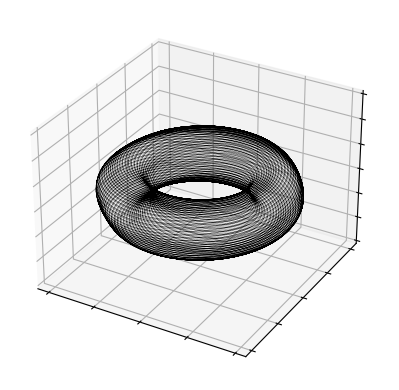

In [18]:
def dmd2torus(a1, a2):
    R1 = np.abs(a1)
    R2 = np.abs(a2)

    phi1 = np.angle(a1)
    phi2 = np.angle(a2)

    x1, y1 = R1 * np.cos(phi1), R1 * np.sin(phi1)
    x2, y2 = R2 * np.cos(phi2), R2 * np.sin(phi2)

    x = x1 + x2 * np.cos(phi1)
    y = y1 + x2 * np.sin(phi1)
    z = y2
    return x, y, z

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(4.5, 4))
ax = fig.add_subplot(projection = '3d')


x, y, z = dmd2torus(a_dmd[:, 0], a_dmd[:, 4])
ax.plot(x, y, z, 'k', lw=0.05)

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.set_zlim([-0.03, .03])

plt.tight_layout()

So these two pairs of DMD coefficients evolve on a 2-torus, which would explain the quasiperiodic dynamics.  What about the other modes?

The answer is a bit complicated (again, see the paper on this topic), but the basic idea is that these are the "driving" degrees of freedom in the flow, while other modes are all generated by "triadic" nonlinear interactions of these dominant modes.  For instance, suppose we have pure oscillations
$$
\alpha_{1} \sim e^{i \omega_s t}
$$
$$
\alpha_{5} \sim e^{i \omega_c t},
$$
with $\alpha_2 = \alpha_1^*$ and $\alpha_6 = \alpha_5^*$ as complex conjugates.
Then a quadratic interaction like $\alpha_1 \alpha_5^*$ would force a higher-order mode at $\omega_s - \omega_c$.  The interaction of _that_ mode with $\alpha_1$ would force yet another mode at $\alpha_1^2 \alpha_5^* \sim e^{i(2\omega_s - \omega_c)t}$.  This pattern of cascading quadratic nonlinearities can therefore explain all of the discrete peaks in the power spectrum.

In short, because the flow is primarily advection-driven, we need many spatial modes to fully resolve the flow, but many fewer active dynamical degrees of freedom.  This is very similar to the seminal paper by [Noack, _et al_. (2003)](https://www.cambridge.org/core/journals/journal-of-fluid-mechanics/article/abs/hierarchy-of-lowdimensional-models-for-the-transient-and-posttransient-cylinder-wake/0F114BEB5DD20B7342E99ED8D0070C01) on the cylinder wake.  Other directions in the subspace may be active during transients, but they are quickly damped out until the flow evolves on the toroidal attractor visualized above.

Note that this torus visualization doesn't _prove_ that these two pairs of DMD modes can explain all of the dynamical behavior (everything else could just be evolving independently), though it is consistent with the power spectrum above. We'll proceed by assuming that these are the only four independent degrees of freedom in the post-transient flow, and try to approximate the other modes as functions of the active degrees of freedom.  That is, if $\boldsymbol{\alpha}$ is the set of the four "active" coefficients, we'll look for
$$
\boldsymbol{\alpha} = \mathbf{g}(\hat{\boldsymbol{\alpha}}).
$$

What should the form of $\mathbf{g}$ be?  Given the discussion about cascading triadic interactions above, a sparse polynomial function would be a good place to start.  We can hijack the library and optimization infrastructure of PySINDy for this!  In other words, we'd write the approximation as
$$
\boldsymbol{\alpha} = \boldsymbol{\Theta}(\hat{\boldsymbol{\alpha}}) \boldsymbol{\xi}
$$
for a polynomial library $\boldsymbol{\Theta}$ and sparse coefficient vector $\boldsymbol{\xi}$.  This looks almost like the SINDy problem
$$
\dot{\mathbf{x}} = \boldsymbol{\Theta}(\mathbf{x}) \boldsymbol{\xi}
$$
except that in this case $\boldsymbol{\alpha}$ and $\hat{\boldsymbol{\alpha}}$ have different numbers of columns.  One subtlety is that PySINDy isn't implemented for complex numbers, so unfortunately we have to separate real and imaginary components of the DMD coefficients, then recombine later.



In [19]:
# Separate real/imaginary parts of the DMD coefficients into one real-valued matrix
a_dmd_real = np.zeros(a_dmd.shape)
a_dmd_real[:,  ::2] = np.real(a_dmd[:, ::2])
a_dmd_real[:, 1::2] = np.imag(a_dmd[:, ::2])

In [20]:
r = 16  # Total number of modes to keep in our manifold model
active_idx = [0, 1, 4, 5]  # Dynamically active modes

# "stable" modes whose amplitudes are functions of a_dmd[active_idx]
stable_idx = [i for i in range(r) if i not in active_idx]  

x_train = a_dmd_real[:, active_idx]  # Inputs to the candidate functions for SINDy
rhs = a_dmd_real[:, stable_idx]      # Targets for the sparse regression problem

manifold_library = ps.PolynomialLibrary(degree=5, include_bias=False)
Theta = manifold_library.fit_transform(x_train)  # Construct the polynomial library

Now we're all set up to solve the optimization problem for `Theta @ Xi = rhs`, where the sparse coefficient vector `Xi` will be stored in `optimizer.coef_`.  We can just call one of the sparse optimizers directly for this.  As in the nonlinear correlations paper, we'll use FROLS here.  Note that if you try this with one of the other optimizers that uses ridge regularization (e.g. STSLQ) you may want to wrap the optimizer in a `pysindy.SINDyOptimizer` with the kwarg `unbias=True` to unbias the final coefficient vector.

In [21]:
# Very ill-conditioned Theta so need to be careful here
print(np.linalg.cond(Theta))
manifold = ps.FROLS(kappa=1e-3 / np.linalg.cond(Theta), alpha=1e-3, max_iter=10)
manifold.fit(Theta, rhs)  # Solve sparse regression problem
print(np.linalg.norm(manifold.coef_, 0, axis=1))  # Number of nonzero terms for each stable mode

6100970657191.033


C:\Users\parth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.86636e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


[3. 3. 4. 4. 4. 4. 6. 6. 6. 6. 6. 6.]


Now with the sparse coefficient vector we have the $\mathbf{g}$ function above and can reconstruct our full vector of DMD coefficients with
$$
\boldsymbol{\alpha} = \mathbf{g}(\hat{\boldsymbol{\alpha}}),
$$
where again, $\hat{\boldsymbol{\alpha}}$ is only 4-dimensional!

In [22]:
def reconstruct(a_dmd_active):
    a_pred_real = np.zeros(a_dmd_real.shape)
    
    # Separate the real/imaginary components of the DMD coefficients
    a_pred_real[:, active_idx[::2]] = np.real(a_dmd_active[:, ::2])
    a_pred_real[:, active_idx[1::2]] = np.imag(a_dmd_active[:, ::2])
    
    # Now reconstruct the real/imag components from the sparse manifold function
    a_pred_real[:, stable_idx] = manifold.predict(
        manifold_library.transform(a_pred_real[:, active_idx])
    )
    
    # Combine real/imaginary parts
    a_pred = np.zeros(a_dmd_real.shape, dtype=np.complex64)
    a_pred[:, ::2] = a_pred_real[:, ::2] + 1j * a_pred_real[:, 1::2]
    a_pred[:, 1::2] = np.conj(a_pred[:, ::2])  # Odd modes are conjugates of even
    return a_pred

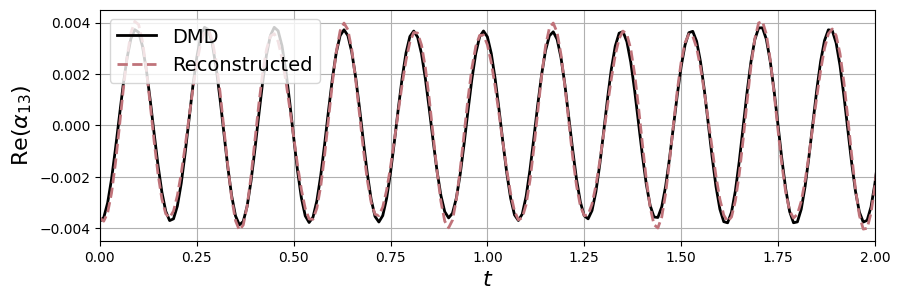

In [23]:
a_pred = reconstruct(a_dmd[:, active_idx])
mode = 13

# Compare the most energetic POD and DMD coefficients
plt.figure(figsize=(10, 3))
plt.plot(t_dns, np.real(a_dmd[:, mode]), label='DMD', c='k', lw=2)
plt.plot(t_dns, np.real(a_pred[:, mode]), 
         label='Reconstructed', lw=2, ls='--', c='xkcd:dusty rose')
plt.xlim([0, 2])
plt.legend(fontsize=14, loc=2)
plt.ylabel(r"Re($\alpha_{{{0}}}$)".format(mode), fontsize=16)
plt.xlabel("$t$", fontsize=16)
plt.grid()
plt.show()

# 6. Manifold SINDy

We're almost to the final reduced-order model, but first let's recap.  We've seen that both standard POD-Galerkin projection and SINDy fail when applied to the leading POD coefficients.  To improve the model, we've taken advantage of the quasiperiodic dynamics in the flow in two ways:
1.  Used Dynamic Mode Decomposition (DMD) to rotate the POD coefficients into a new generalized coordinate system where the dynamics are closer to pure oscillation
2.  Used sparse polynomial regression to identify a manifold equation that maps from the four "active" degrees of freedom $\hat{\boldsymbol{\alpha}}$ to the full DMD coefficient vector: $\boldsymbol{\alpha} = \mathbf{g}(\hat{\boldsymbol{\alpha}})$.

At this point we just need to learn a dynamical model for those four degrees of freedom.  Then we can use our manifold equation and the DMD transformation to map back to the POD modes, which can in turn reconstruct the full flow field:
$$
\frac{d \hat{\boldsymbol{\alpha}} }{d t} = \mathbf{f}(\boldsymbol{\hat{\alpha}})
$$
$$
\mathbf{a}(t) = \mathbf{V} \mathbf{g}(\hat{\boldsymbol{\alpha}}(t))
$$
$$
\mathbf{u}(\mathbf{x}, t) = \sum_{j=1}^r \boldsymbol{\psi}_j(\mathbf{x}) a_j(t).
$$
In other words, we just need to use standard SINDy to learn a sparse polynomial approximation to $\mathbf{f}$ (though again, remember we need to do this with separate real/imaginary parts).

One last trick: we expect the system to have the symmetry that $\mathbf{f}(-\hat{\boldsymbol{\alpha}}) = -\mathbf{f}( \hat{\boldsymbol{\alpha}} ) $.  We can encode this in the library very easily by just adding the negative of the training data as a separate trajectory in PySINDy:

In [24]:
# Construct training data with negative symmetry
x_train = [a_dmd_real[:, active_idx], -a_dmd_real[:, active_idx]]
t_train = [t_dns, t_dns]

# Fit the model
optimizer = ps.STLSQ(threshold=1e-3)
library = ps.PolynomialLibrary(degree=3, include_bias=False)
model = ps.SINDy(
    optimizer=optimizer, 
    feature_library=library, 
    feature_names=["a_1", "a_2", "a_5", "a_6"]
)
model.fit(x_train, t_train, multiple_trajectories=True, quiet=True)
model.print()

(a_1)' = 10.292 a_2 + 1668.550 a_1^2 a_2 + 1668.950 a_2^3
(a_2)' = -10.129 a_1 + -1868.514 a_1^3 + -1868.873 a_1 a_2^2
(a_5)' = 3.418 a_6 + -667.927 a_1^2 a_6 + -668.229 a_2^2 a_6
(a_6)' = -3.230 a_5 + 438.250 a_1^2 a_5 + 439.406 a_2^2 a_5


SINDy identifies a generalized Stuart-Landau-type system of equations that describes a pair of coupled oscillators.  Again, this is slightly different from the paper referenced above, where uncoupled oscillators were identified.  The difference is probably because the paper looked at the complex-valued coefficients; since the DMD coefficients are _almost_ pure oscillators, any slight difference in the input variables can lead to slightly different models.  This one isn't as "good" as the one in the paper, in that it probably wouldn't capture transient behavior very well, but it's not bad either.  Let's simulate and check:

In [25]:
a_pred_real = model.simulate(x_train[0][0], t_train[0])

# Combine into complex-conjugate DMD coefficients
a_pred = np.zeros_like(a_dmd[:, active_idx])
a_pred[:,  ::2] = a_pred_real[:, ::2] + 1j * a_pred_real[:, 1::2]
a_pred[:, 1::2] = a_pred_real[:, ::2] - 1j * a_pred_real[:, 1::2]

Now we can check that the solution is living on the torus as we expect:

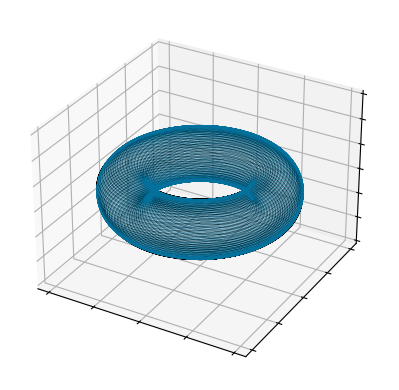

In [27]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(4.5, 4))
ax = fig.add_subplot(projection = '3d')


x, y, z = dmd2torus(a_dmd[:, 0], a_dmd[:, 4])
ax.plot(x, y, z, 'k', lw=0.05)

x, y, z = dmd2torus(a_pred[:, 0], a_pred[:, 2])
ax.plot(x, y, z, c='xkcd:ocean blue', lw=0.05)

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.set_zlim([-0.03, .03])

plt.tight_layout()

Note that the generalized Stuart-Landau system describes two coupled oscillators - that's only two distinct frequencies.  But this is in the space of just the "active" coefficients $\hat{\boldsymbol{\alpha}}$.  We still have to use our manifold function to reconstruct all the stable modes.  First, the POD coefficients can be reconstructed to compare to the DNS time series directly:

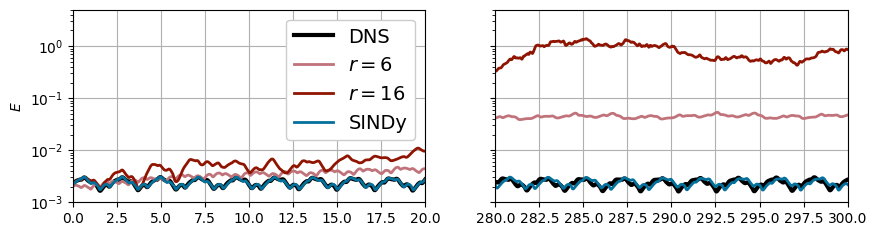

In [28]:
a_sindy = np.real(V @ reconstruct(a_pred).T).T
E_sindy = np.sum(a_sindy[:, :rE] ** 2, 1)

plt.figure(figsize=(10, 2.5))
plt.subplot(1, 2, 1)
plt.plot(t_dns, E_dns, 'k', label='DNS', lw=3)
plt.plot(t_sim, E_gal6, label='$r=6$', lw=2, c='xkcd:dusty rose')
plt.plot(t_sim, E_gal16, label='$r=16$', lw=2, c='xkcd:brick red')
plt.plot(t_sim, E_sindy, label='SINDy', lw=2, c='xkcd:ocean blue')
plt.gca().set_yscale('log')
plt.legend(loc=0, fancybox=True, framealpha=1, fontsize=14)
plt.xlim([0, 20])
plt.ylim([1e-3, 5e0])
plt.ylabel('$E$')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(t_dns, E_dns, 'k', label='DNS', lw=3)
plt.plot(t_sim, E_gal6, label='$r=6$', lw=2, c='xkcd:dusty rose')
plt.plot(t_sim, E_gal16, label='$r=16$', lw=2, c='xkcd:brick red')
plt.plot(t_sim, E_sindy, label='SINDy', lw=2, c='xkcd:ocean blue')
plt.gca().set_yscale('log')
plt.xlim([280, 300])
plt.ylim([1e-3, 5e0])
plt.gca().set_yticklabels([])
plt.grid()

plt.subplots_adjust(wspace=0.2)
plt.show()

Over time the solutions drift out of alignment a bit, but overall the agreement is pretty nice.  Finally, the reconstructed coefficients can be used to estimate the power spectral density.  The approximately discrete point spectrum confirms that the model is quasiperiodic, and the nonlinear manifold reconstruction lets us capture all of the different frequencies that were missing in the low-dimensional model.

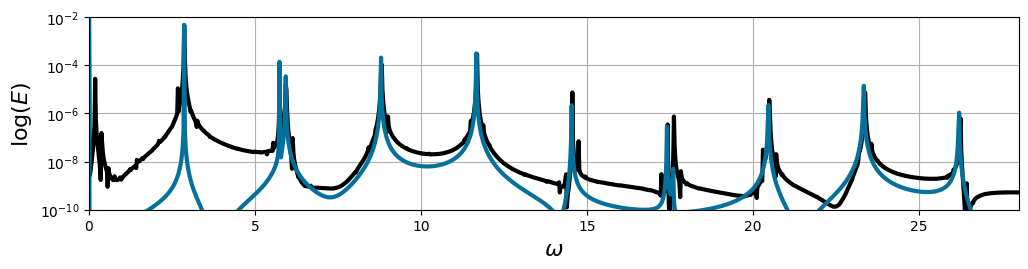

In [29]:
E_dns = np.sum(a_dns[:, :rE] ** 2, axis=1)
E_sindy = np.sum(a_sindy[:, :rE] ** 2, axis=1)

psd, freq = psd_est(E_dns, dt=t_dns[1] - t_dns[0])
psd_sim, freq_sim = psd_est(E_sindy, dt=t_sim[1] - t_sim[0])
    
plt.figure(figsize=(12, 2.5))
plt.semilogy(freq, psd, 'k', lw=3)
plt.semilogy(freq_sim, psd_sim, 'xkcd:ocean blue', lw=3)
plt.xlim([0, 28])
plt.ylim([1e-10, 1e-2])
plt.xlabel('$\omega$', fontsize=16)
plt.ylabel('$\log(E)$', fontsize=16)
plt.grid()
plt.show()

To review, we started with a system that looked significantly harder to model than the cylinder wake: we had more complicated quasiperiodic dynamics, a slowly converging singular value spectrum, and both standard POD-Galerkin and SINDy models failed.

But once we had some insight into the underlying dynamics, we could use some simple transformations (DMD) and features of the PySINDy package (directly accessing the optimizers to learn a the manifold equation, and using multiple trajectories to enforce symmetry) to reduce the complexity of the problem until we could identify a much simpler and more accurate 4-dimensional model that does a nice job of capturing the dynamics of the flow.